In [2]:
# Data taken from
# https://survstat.rki.de/Content/Query/Create.aspx

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("campylobacter_data.csv", encoding="utf-16", sep="\s+")
df = df.drop(columns=["Total", "Unnamed: 0"])
df = df.drop(index=df.index[0])
df.values.flatten().tolist()
campy = [x for x in df.values.flatten().tolist() if pd.notna(x)]

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_9258/673834506.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("campylobacter_data.csv", encoding="utf-16", sep="\s+")


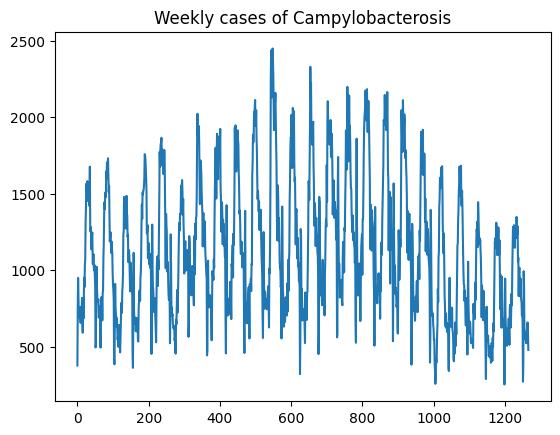

In [3]:
plt.plot(campy)
plt.title("Weekly cases of Campylobacterosis")
plt.show()

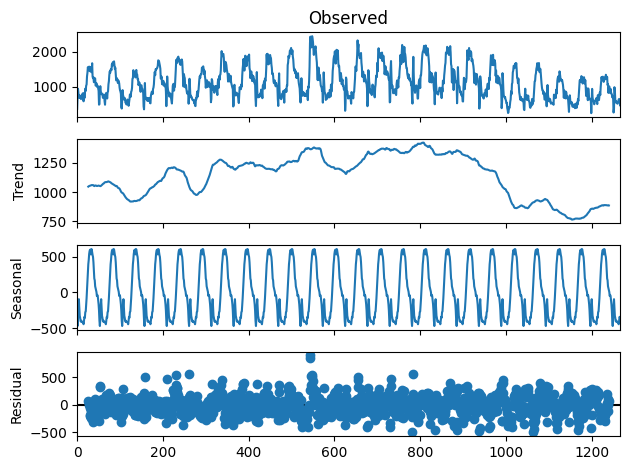

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(campy, period=52)

decomp.plot()
plt.show()

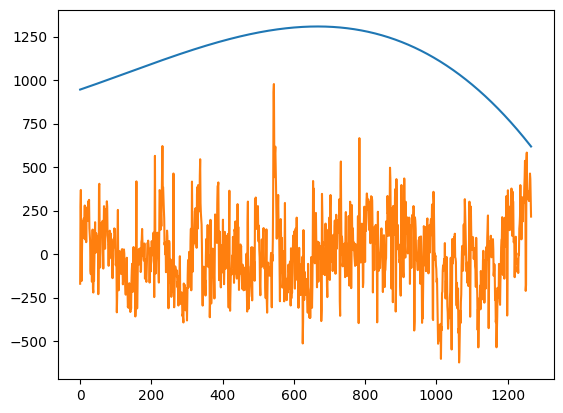

In [6]:
trend_coeffs = np.polyfit(range(len(campy)), campy, 3)
trend_line = np.polyval(trend_coeffs, range(len(campy)))

plt.plot(trend_line)
campy_clean = campy - decomp.seasonal - trend_line
plt.plot(campy_clean)
plt.show()

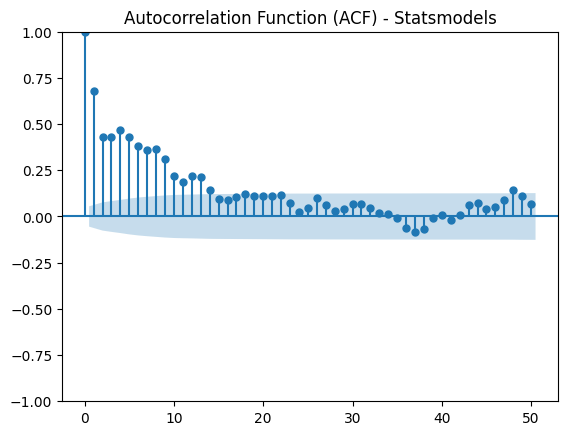

In [7]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function using statsmodels
plot_acf(campy_clean, lags=50)
plt.title("Autocorrelation Function (ACF) - Statsmodels")
plt.show()

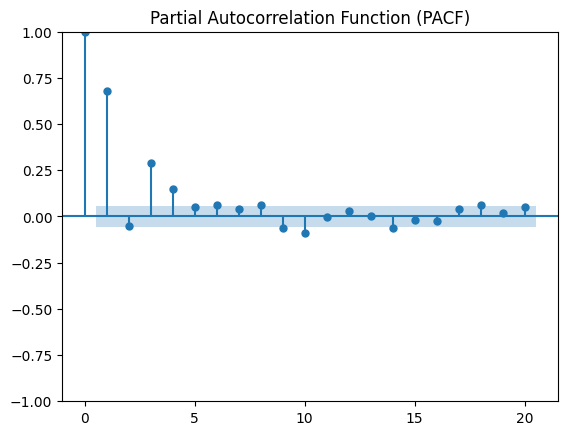

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the partial autocorrelation function
plot_pacf(campy_clean, lags=20, method='ywmle')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [10]:
import statsmodels.tsa.arima.model as ARIMA

p = 4
q = 15

aics = np.zeros((p, q))

for ar in range(p):
    for ma in range(q):
        model = ARIMA.ARIMA(campy_clean, order=(ar, 0, ma))
        results = model.fit()
        aics[ar, ma]  = results.aicc

data = aics

# Define AR and MA ranges
p_range = range(data.shape[0])  # AR terms
q_range = range(data.shape[1])  # MA terms

# Create DataFrame for nice formatting
df = pd.DataFrame(data, index=[f"AR({p})" for p in p_range], columns=[f"MA({q})" for q in q_range])

# Print the table
print("AIC Table (rows: AR order, columns: MA order):\n")
print(df)

# Find and print the minimum value and its location
min_val = df.min().min()
min_loc = df.stack().idxmin()

print(f"\nMinimum value: {min_val:.4f} at {min_loc}")

/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

AIC Table (rows: AR order, columns: MA order):

              MA(0)         MA(1)         MA(2)         MA(3)         MA(4)  \
AR(0)  17070.294752  16445.982476  16336.056832  16326.553618  16283.428764   
AR(1)  16294.019303  16284.547401  16172.191883  16174.219422  16146.098210   
AR(2)  16292.753419  16272.765081  16174.210003  16162.774913  16145.147434   
AR(3)  16184.387507  16147.123952  16149.151157  16150.507951  16122.260014   

              MA(5)         MA(6)         MA(7)         MA(8)         MA(9)  \
AR(0)  16253.827037  16225.984566  16217.465536  16208.013454  16171.473748   
AR(1)  16146.369882  16147.426209  16149.342473  16146.033718  16147.237427   
AR(2)  16146.181772  16147.987951  16149.657276  16147.772035  16147.473504   
AR(3)  16124.140587  16106.434749  16126.847520  16114.114191  16110.596047   

             MA(10)        MA(11)        MA(12)        MA(13)        MA(14)  
AR(0)  16155.944282  16156.252582  16158.255209  16139.866119  16137.513021  
AR(1

/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


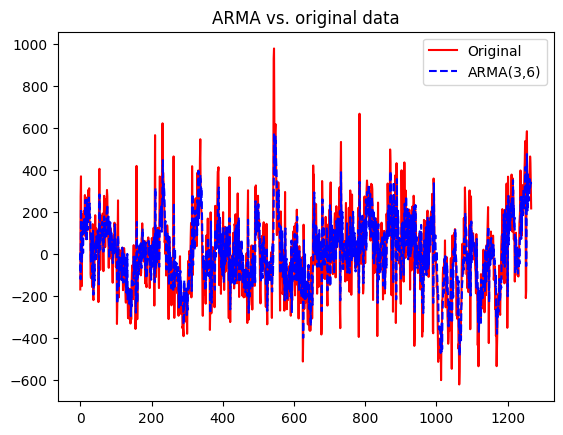

In [18]:
import statsmodels.tsa.arima.model as ARIMA

model = ARIMA.ARIMA(campy_clean, order=(3, 0, 6))
results = model.fit()

plt.plot(campy_clean, "r", label="Original")
plt.plot(results.fittedvalues, "b--", label="ARMA(3,6)")
plt.legend()
plt.title("ARMA vs. original data")
plt.show()

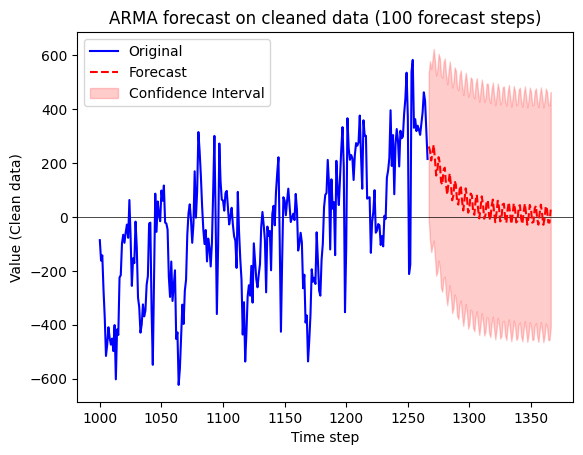

In [68]:
forcast_data = results.get_forecast(100)
conf = forcast_data.conf_int()

lower_conf = conf[:, 0]
upper_conf = conf[:, 1]

a = len(campy_clean[1000:])
b = len(forcast_data.predicted_mean)

plt.axhline(0, color="black", linewidth=0.5)
plt.plot(range(1000, 1000 + a), campy_clean[1000:], "b", label="Original")
plt.plot(range(1000 + a, 1000 + a+b), forcast_data.predicted_mean, "r--", label="Forecast")
plt.fill_between(range(1000 + a, 1000 + a+b), lower_conf, upper_conf, color="r", label="Confidence Interval", alpha=.2)
plt.legend()
plt.ylabel("Value (Clean data)")
plt.xlabel("Time step")
plt.title("ARMA forecast on cleaned data (100 forecast steps)")
plt.show()

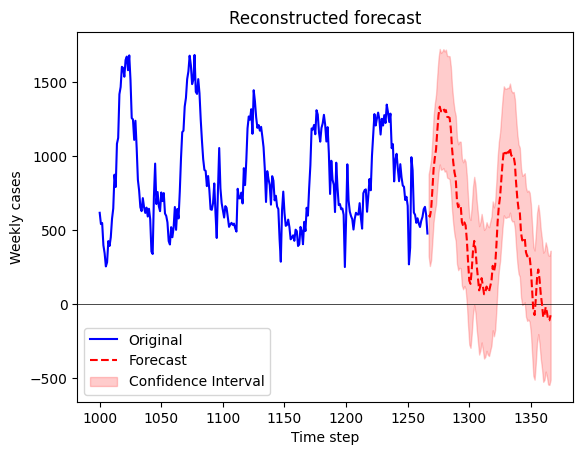

In [63]:
reconstructed_trend = np.polyval(trend_coeffs, range(len(campy_clean), len(campy_clean)+len(forcast_data.predicted_mean)))

seasonal_cycle = decomp.seasonal[-52:]
seasonal_forecast = np.tile(seasonal_cycle, int(np.ceil(len(forcast_data.predicted_mean)/52)))[:len(forcast_data.predicted_mean)]

reconstructed_forecast = reconstructed_trend + forcast_data.predicted_mean + seasonal_forecast

lower_conf = conf[:, 0] + reconstructed_trend + seasonal_forecast
upper_conf = conf[:, 1] + reconstructed_trend + seasonal_forecast

dat1 = campy
dat2 = reconstructed_forecast

c = len(dat1[1000:])
d = len(dat2)

plt.axhline(0, color="black", linewidth=0.5)
plt.plot(range(1000, 1000 + c), dat1[1000:], "b", label="Original")
plt.plot(range(1000 + c, 1000 + c+d), dat2, "r--", label="Forecast")
plt.fill_between(range(1000 + c, 1000 + c+d), lower_conf, upper_conf, color="r", label="Confidence Interval", alpha=.2)
plt.title("Reconstructed forecast")
plt.ylabel("Weekly cases")
plt.xlabel("Time step")
plt.legend()
plt.show()